# 統計的相関機能

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tatsuki-washimi/gwexpy/blob/main/docs/web/en/user_guide/tutorials/advanced_correlation.ipynb)

gwexpyでは、TimeSeriesオブジェクト間の統計的相関を簡単に計算できます。これはノイズハンティングや非線形結合の調査に役立ちます。

サポートされている手法:
- **Pearson (PCC)**: 線形相関。
- **Kendall (Ktau)**: 順位相関（外れ値に強く、ノンパラメトリック）。
- **MIC**: Maximal Information Coefficient（非線形関係に対してロバスト、`minepy`が必要、`python scripts/install_minepy.py`で構築）。

In [1]:
import sys
from pathlib import Path

root = Path.cwd()
for _ in range(6):
    if (root / "gwexpy").exists():
        if str(root) not in sys.path:
            sys.path.insert(0, str(root))
        break
    root = root.parent

import matplotlib.pyplot as plt
import numpy as np

from gwexpy.plot import PairPlot, Plot
from gwexpy.timeseries import TimeSeries, TimeSeriesMatrix

## ペアごとの相関

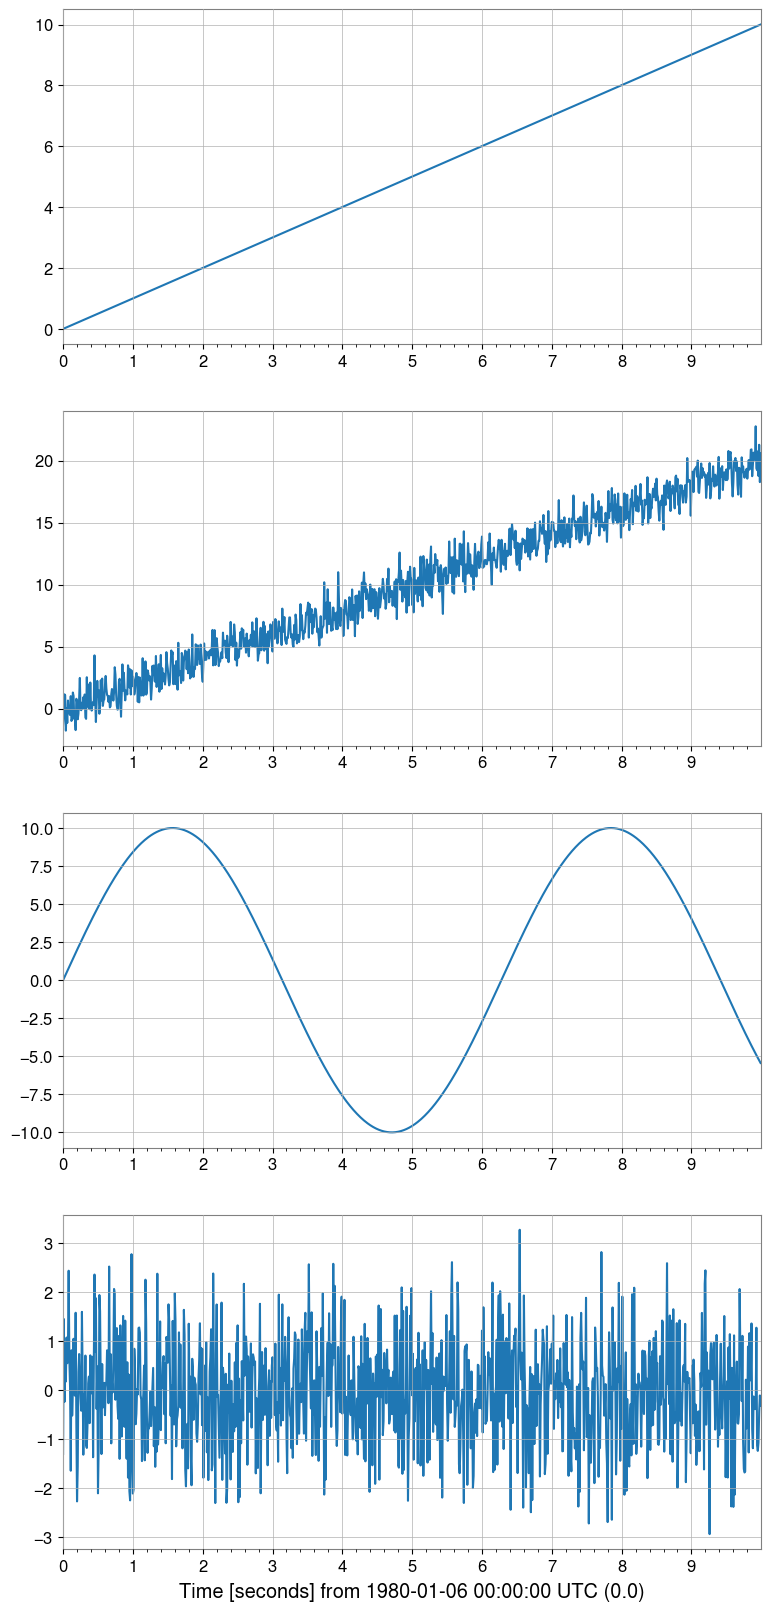

In [2]:
# Data Create
t = np.linspace(0, 10, 1000)

#
ts_a = TimeSeries(t, dt=0.01, name="A")
ts_b = TimeSeries(t * 2 + np.random.normal(0, 1, 1000), dt=0.01, name="B_Linear")

# (Sine wave)
ts_c = TimeSeries(np.sin(t) * 10, dt=0.01, name="C_Sine")

# Noise
ts_d = TimeSeries(np.random.normal(0, 1, 1000), dt=0.01, name="D_Noise")

Plot(ts_a, ts_b, ts_c, ts_d, separate=True, sharex=True);

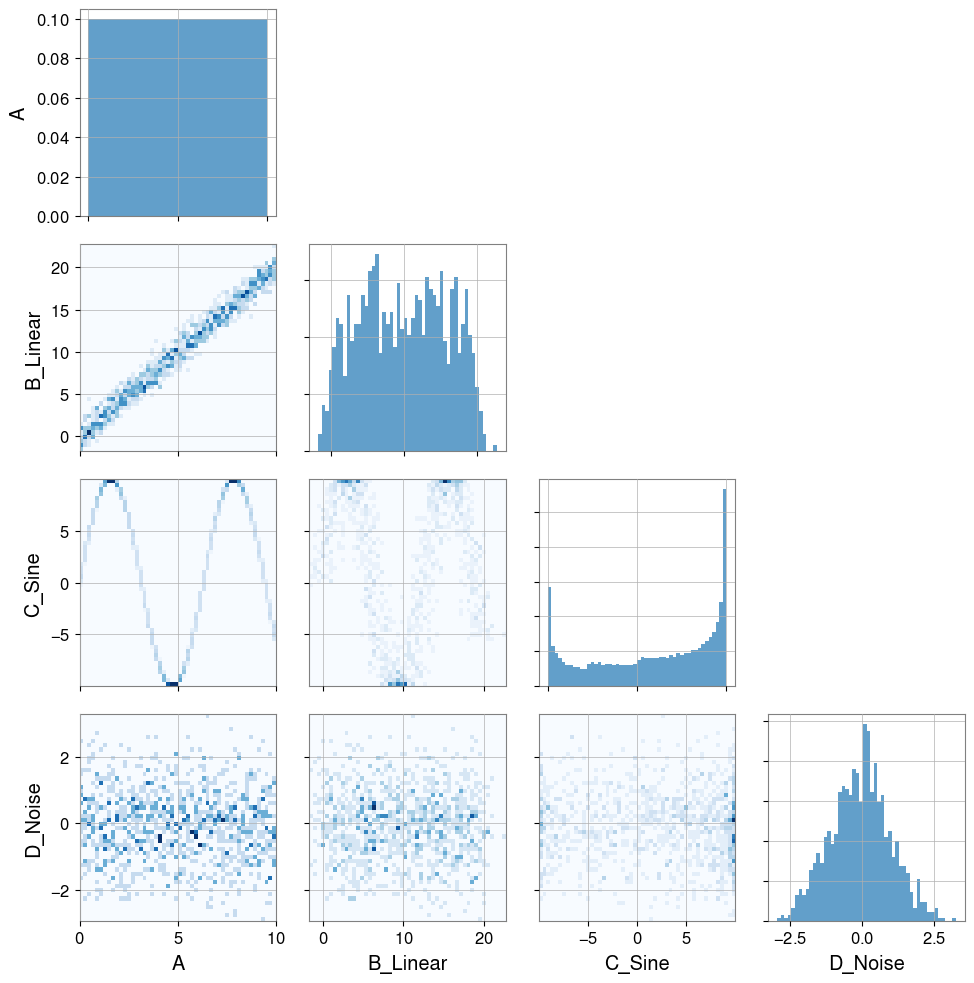

In [3]:
# Visualization
pair = PairPlot([ts_a, ts_b, ts_c, ts_d], corner=True)
pair.show()

In [4]:
print("Correlation A vs B ( ):")
print(f" Pearson: {ts_a.pcc(ts_b):.3f}")
print(f" Kendall: {ts_a.ktau(ts_b):.3f}")
try:
    print(f" MIC: {ts_a.mic(ts_b):.3f}")
except ImportError:
    print(" MIC: (minepy )")

Correlation A vs B ( ):
 Pearson: 0.985
 Kendall: 0.892
 MIC: (minepy )


In [5]:
print("Correlation A vs C ( Sine wave):")
print(f" Pearson: {ts_a.pcc(ts_c):.3f} ( Correlation )")
print(f" Kendall: {ts_a.ktau(ts_c):.3f}")
try:
    print(f" MIC: {ts_a.mic(ts_c):.3f} ( )")
except ImportError:
    print(" MIC: (minepy )")

Correlation A vs C ( Sine wave):
 Pearson: -0.071 ( Correlation )
 Kendall: -0.053
 MIC: (minepy )


## 相関ベクトル (ノイズハンティング)

ノイズ源を調査する際、ターゲットチャンネル（例：DARM）と数百の補助チャンネルとの間の相関を確認したいことがよくあります。
`TimeSeriesMatrix.correlation_vector` はこのランキングを効率的に計算します。

In [6]:
# havingMatrix Create
n_channels = 20
data = np.random.randn(n_channels, 1, 1000)
names = [f"AUX-{i:02d}" for i in range(n_channels)]

# AUX-05 AUX-12 Signal
target_signal = np.sin(np.linspace(0, 20, 1000))
data[5, 0, :] += target_signal * 5 #
data[12, 0, :] += target_signal**2 * 5 #

matrix = TimeSeriesMatrix(data, dt=0.01, channel_names=names)

#
target = TimeSeries(
    target_signal + np.random.normal(0, 0.1, 1000), dt=0.01, name="TARGET"
)

In [7]:
# CorrelationVector Calculate
# 'mic' （ ）
# Velocity 'pearson'

try:
    print("MICVector Calculate (Top 5)...")
    df_mic = matrix.correlation_vector(target, method="mic", parallel=2)
    print(df_mic.head(5))
except ImportError:
    print("minepy 、MIC 。")

MICVector Calculate (Top 5)...
minepy 、MIC 。


In [8]:
print("PearsonVector Calculate (Top 5)...")
df_pcc = matrix.correlation_vector(target, method="pearson", parallel=1)
print(df_pcc.head(5))

PearsonVector Calculate (Top 5)...
   row  col channel     score
0    5    0  AUX-05  0.952315
1   10    0  AUX-10  0.055887
2   18    0  AUX-18 -0.048783
3   17    0  AUX-17  0.040776
4    3    0  AUX-03  0.039967


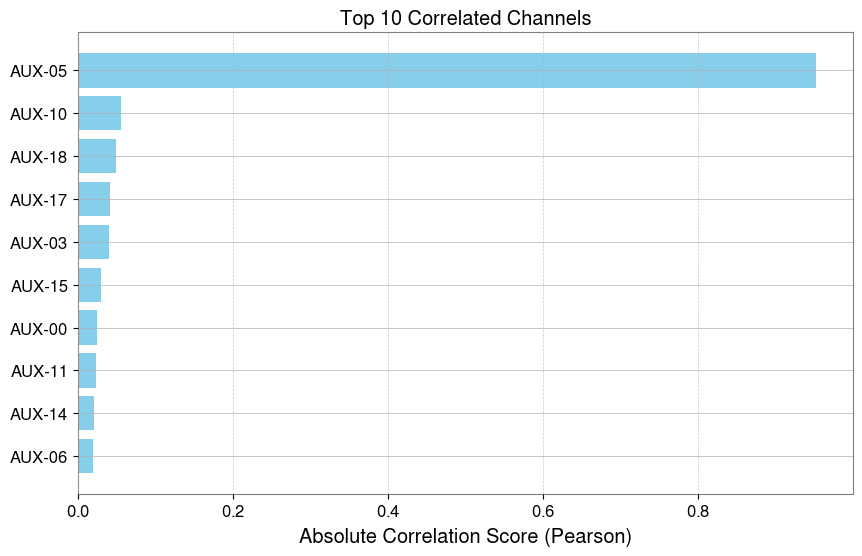

In [9]:
# Visualization (Top 10)
df_plot = df_pcc.head(10).iloc[::-1] # do

plt.figure(figsize=(10, 6))
plt.barh(df_plot["channel"], np.abs(df_plot["score"]), color="skyblue")
plt.xlabel("Absolute Correlation Score (Pearson)")
plt.title("Top 10 Correlated Channels")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

## 偏相関（共通要因の除去）

共通の要因を取り除いて、直接的な結びつきを評価します。


In [10]:
import numpy as np

from gwexpy.timeseries import TimeSeries

rng = np.random.default_rng(0)
t = np.linspace(0, 10, 1000)
z = np.sin(2 * np.pi * 0.5 * t) + 0.1 * rng.standard_normal(t.size)
x = z + 0.1 * rng.standard_normal(t.size)
y = z + 0.1 * rng.standard_normal(t.size)

ts_x = TimeSeries(x, dt=t[1] - t[0], name="x")
ts_y = TimeSeries(y, dt=t[1] - t[0], name="y")
ts_z = TimeSeries(z, dt=t[1] - t[0], name="z")

print("corr(x,y):", ts_x.correlation(ts_y, method="pearson"))
print("partial corr(x,y|z):", ts_x.partial_correlation(ts_y, controls=ts_z, method="residual"))


corr(x,y): 0.9809075921667307
partial corr(x,y|z): 0.004410452860247931


## Association Edges / グラフ化

ターゲット時系列に対して行列の各チャンネルを評価し、エッジを作成します。


In [11]:
from gwexpy.analysis import association_edges, build_graph
from gwexpy.timeseries import TimeSeriesMatrix

matrix = TimeSeriesMatrix(
    np.stack([x, y, z], axis=0)[:, None, :],
    dt=t[1] - t[0],
    channel_names=["x", "y", "z"],
)

edges = association_edges(ts_x, matrix, method="pearson", topk=3)
print(" :\n", edges)

pcorr = matrix.partial_correlation_matrix(shrinkage="auto")
print(" CorrelationMatrix:\n", pcorr)


# networkx Plot :
graph = build_graph(edges, backend="none")
print("Plot ")


 :
    row  col channel     score source target
0    0    0       x  1.000000      x      x
1    2    0       z  0.989968      x      z
2    1    0       y  0.980908      x      y
 CorrelationMatrix:
 [[1.         0.1216813  0.6444092 ]
 [0.1216813  1.         0.67131295]
 [0.6444092  0.67131295 1.        ]]
Plot 


### 可視化: エッジランキングと偏相関ヒートマップ


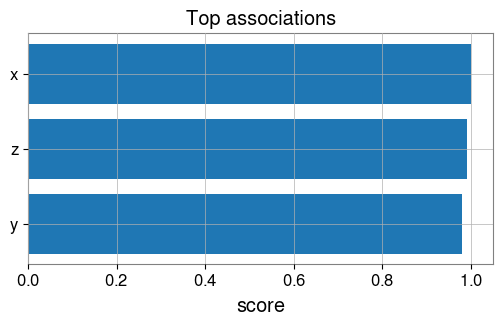

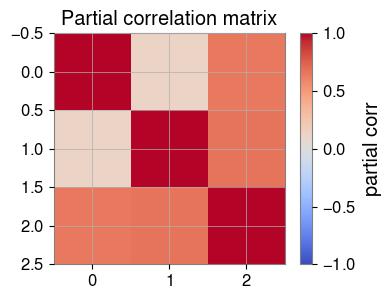

In [12]:
import matplotlib.pyplot as plt

# Bar plot of top edges
top = edges.sort_values('score', ascending=False, key=abs).head(10)
plt.figure(figsize=(6, 3))
plt.barh(top['target'], top['score'])
plt.gca().invert_yaxis()
plt.xlabel('score')
plt.title('Top associations')
plt.show()

# Heatmap of partial correlation
plt.figure(figsize=(4, 3))
plt.imshow(pcorr, vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar(label='partial corr')
plt.title('Partial correlation matrix')
plt.show()


## FastMI（実験的）

FastMI は、copula（経験CDF）+ probit 変換 + FFT ベースの self-consistent 密度推定を用いた相互情報量 (MI) 推定です。

- API: `TimeSeries.fastmi(other, grid_size=..., quantile=..., eps=...)` または `correlation(other, method="fastmi")`
- 出力: MI（**nats**、0以上）。値が大きいほど依存が強い（線形/非線形を問わない）。
- パラメータ:
  - `grid_size`: FFT グリッド分解能（精度と速度のトレードオフ）。
  - `quantile`: probit の極端な裾をトリムして安定化。
  - `eps`: `log(0)` 回避のための下限。


In [13]:
# fastMI (copula/probit + FFT-based MI estimator)
# NOTE: this can be slower than Pearson for small n, but is useful for nonlinear dependence.
print('fastMI(x,y):', ts_x.fastmi(ts_y, grid_size=128))
print('fastMI(x,z):', ts_x.fastmi(ts_z, grid_size=128))


fastMI(x,y): 0.08925170168547956
fastMI(x,z): 0.11320579203180094


## CAGMon 風の Association Graph（最小実装）

エッジリストからグラフを作り、必要なら可視化します。


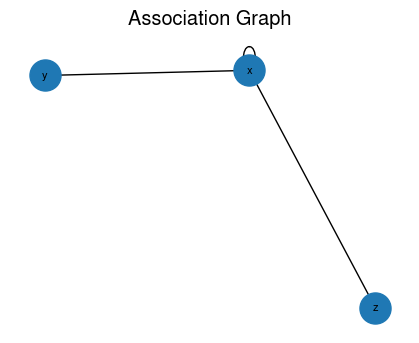

In [14]:
# If networkx is available, you can visualize the association graph
try:
    import networkx as nx
    G = build_graph(edges, backend='networkx')
    plt.figure(figsize=(4, 3))
    pos = nx.spring_layout(G, seed=0)
    nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
    plt.title('Association Graph')
    plt.show()
except Exception as e:
    print('Graph plot skipped:', e)


# 高度な統計解析 (Advanced Statistics)

gwexpyは、相関だけでなく、データの分布形状や因果関係を調べるための高度な統計機能も提供しています。

- **Skewness (歪度)**: 分布の非対称性。
- **Kurtosis (尖度)**: 分布の裾の重さ（外れ値の多さ）。
- **Distance Correlation (dCor)**: 非線形な依存関係の尺度。
- **Granger Causality**: 時系列間の因果関係（予測への寄与）。

## 非ガウス性ノイズの検出 (Skewness / Kurtosis)

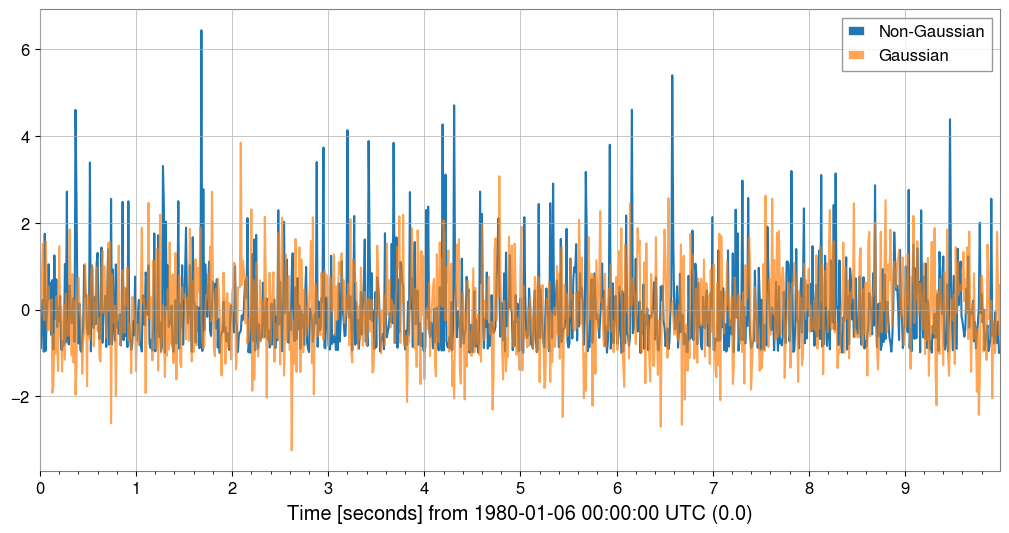

Gaussian: Skewness=0.117, Kurtosis=0.066
Non-Gaussian: Skewness=1.981, Kurtosis=5.379
Note: Gaussianminutes Skewness~0, Kurtosis~0 (FisherDefine) 。


In [15]:
# GaussianNoise GaussianNoise（ minutes ） Generate
np.random.seed(42)
gauss_noise = TimeSeries(np.random.normal(0, 1, 1000), dt=0.01, name="Gaussian")
exp_noise = TimeSeries(
    np.random.exponential(1, 1000) - 1, dt=0.01, name="Non-Gaussian"
) #

# Plot
plot = exp_noise.plot(label="Non-Gaussian")
plot.gca().plot(gauss_noise, label="Gaussian", alpha=0.7)
plot.gca().legend()
plot.show()

# Calculate
print(
    f"Gaussian: Skewness={gauss_noise.skewness():.3f}, Kurtosis={gauss_noise.kurtosis():.3f}"
)
print(
    f"Non-Gaussian: Skewness={exp_noise.skewness():.3f}, Kurtosis={exp_noise.kurtosis():.3f}"
)
print("Note: Gaussianminutes Skewness~0, Kurtosis~0 (FisherDefine) 。")

## 非線形依存性の検出 (Distance Correlation)

先ほどの正弦波データ(`ts_c`)と線形データ(`ts_a`)の関係をdCorで見てみましょう。Pearson相関では捉えられなかった関係が検出できます。

In [16]:
try:
    dcor_val = ts_a.distance_correlation(ts_c)
    print(f"Distance Correlation (A vs C): {dcor_val:.3f}")
    print(f"Pearson Correlation (A vs C): {ts_a.pcc(ts_c):.3f}")
except ImportError:
    print(
        "dcorPackage 。pip install dcor 。"
    )

Distance Correlation (A vs C): 0.381
Pearson Correlation (A vs C): -0.071


## 因果関係の推定 (Granger Causality)

ある時系列の過去の値が、別の時系列の未来の値を予測するのに役立つかどうかを検定します。

In [17]:
# Data Generate (X -> Y)
np.random.seed(0)
n = 200
x_val = np.random.randn(n)
y_val = np.zeros(n)
# Y X 1
for i in range(1, n):
    y_val[i] = 0.5 * y_val[i - 1] + 0.8 * x_val[i - 1] + 0.1 * np.random.randn()

ts_x = TimeSeries(x_val, dt=1, name="Cause (X)")
ts_y = TimeSeries(y_val, dt=1, name="Effect (Y)")

try:
    # X Y ？ (Y X ？) -> p
    p_xy = ts_y.granger_causality(ts_x, maxlag=5)

    # Y X ？ -> p
    p_yx = ts_x.granger_causality(ts_y, maxlag=5)

    print(
        f"Granger Causality X -> Y (p-value): {p_xy:.4f} {'(Significant)' if p_xy < 0.05 else ''}"
    )
    print(
        f"Granger Causality Y -> X (p-value): {p_yx:.4f} {'(Significant)' if p_yx < 0.05 else ''}"
    )
except ImportError:
    print(
        "statsmodelsPackage 。pip install statsmodels 。"
    )

Granger Causality X -> Y (p-value): 0.0000 (Significant)
Granger Causality Y -> X (p-value): 0.0907 


## 高速相互情報量推定 (fastmi)

`fastmi` は、コピュラ（Copula）定式化、プロビット（Probit）変換、およびFFTベースの密度推定に基づく高速な相互情報量（Mutual Information）推定器です。Pearson相関が見逃す可能性のある複雑な非線形依存関係を捉えることができます。

In [18]:
mi_xy = ts_x.fastmi(ts_y, grid_size=128)
mi_xz = ts_x.fastmi(ts_z, grid_size=128)

print(f"Cross (x, y): {mi_xy:.4f} nats")
print(f"Cross (x, z): {mi_xz:.4f} nats")

Cross (x, y): 0.0195 nats
Cross (x, z): 0.0000 nats


/home/washimi/work/gwexpy/gwexpy/timeseries/_statistics.py:263: UserWarning: Sample rates do not match. Resampling 'other' to match 'self'.
  warnings.warn(
